In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, mean_squared_error
import copy

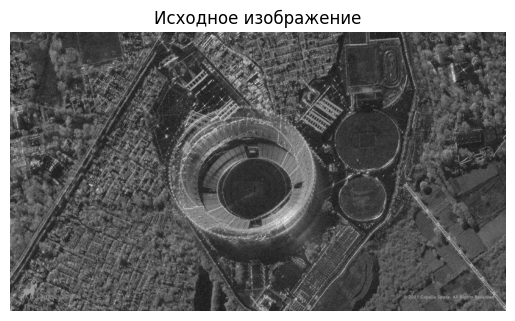

In [49]:
# Загрука изображения
image_path = 'sar_1.jpg'
image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image_gray is None:
    raise FileNotFoundError(f"Изображение {image_path} не найдено!")

plt.imshow(image_gray, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

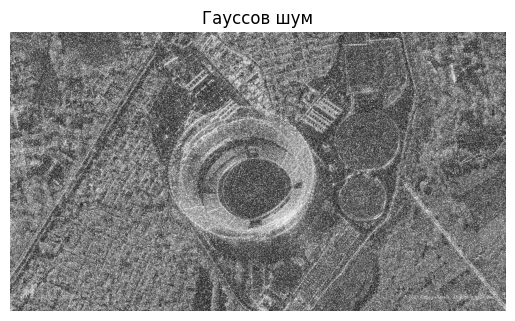

In [123]:
# Фильтр Гаусса
mean = 0
stddev = 100
noise_gauss = np.zeros(image_gray.shape, np.uint8)
cv2.randn(noise_gauss, mean, stddev)
image_noise_gauss = cv2.add(image_gray,noise_gauss)

plt.imshow(image_noise_gauss, cmap="gray")
plt.axis('off')
plt.title('Гауссов шум')
plt.show()

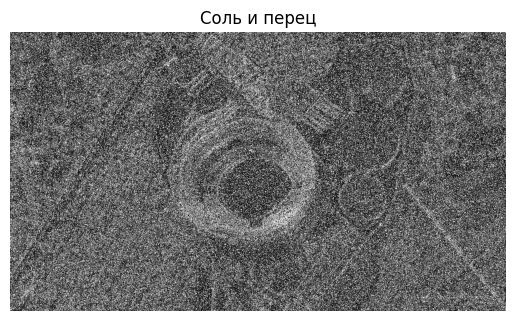

In [115]:
# Соль и перец
noise =  np.random.randint(0, 5, size = (image_gray.shape[0], image_gray.shape[1]), dtype=int)
zeros_pixel = np.where(noise == 0)
ones_pixel = np.where(noise == 4)
bg_image = image_gray.copy().astype(np.uint8)
bg_image[zeros_pixel] = 0
bg_image[ones_pixel] = 255

plt.imshow(bg_image, cmap="gray")
plt.axis('off')
plt.title('Соль и перец')
plt.show()


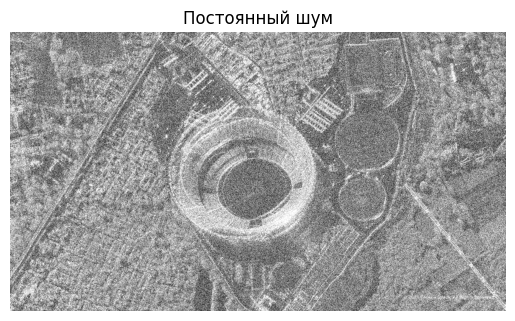

In [35]:
# Постоянный шум
a = 0 # нижняя граница
b = 150 # верхняя граница

height, width = image_gray.shape
noise = np.random.uniform(a, b, (height, width)) # Создание шума

noisy_image = image_gray.astype(np.float32) + noise # Добавление шума к изображению
noisy_image = np.clip(noisy_image, 0, 255) # Обрезаем до допустимого диапозона
noisy_image = noisy_image.astype(np.uint8)

plt.imshow(noisy_image, cmap="gray")
plt.axis('off')
plt.title('Постоянный шум')
plt.show()

In [120]:
# Фильтры для Гауссова шума

# Медианный фильтр
image_gauss_median3 = cv2.medianBlur(image_noise_gauss, 3)
image_gauss_median5 = cv2.medianBlur(image_noise_gauss, 5)

# Фильтр Гаусса
image_gauss_gauss3 = cv2.GaussianBlur(image_noise_gauss, (3, 3), 0)
image_gauss_gauss5 = cv2.GaussianBlur(image_noise_gauss, (5, 5), 0)

# Билатеральный фильтр
image_gauss_bilat1 = cv2.bilateralFilter(image_noise_gauss, 9, 50, 50)
image_gauss_bilat2 = cv2.bilateralFilter(image_noise_gauss, 9, 100, 100)

# Фильтр нелокальных средних
image_gauss_nlm = cv2.fastNlMeansDenoising(image_noise_gauss, h=20)

Результаты для гауссова шума:
Медианный 3x3: MSE=1027.12, SSIM=0.4315
Медианный 5x5: MSE=700.64, SSIM=0.4713
Гаусс 3x3: MSE=1896.62, SSIM=0.4418
Гаусс 5x5: MSE=1757.52, SSIM=0.4879
Билатеральный 50: MSE=2652.67, SSIM=0.2282
Билатеральный 100: MSE=1559.18, SSIM=0.3894
NLM h=20: MSE=4220.26, SSIM=0.1879

Лучший фильтр для гауссова шума: Медианный 5x5
MSE: 700.64, SSIM: 0.4713


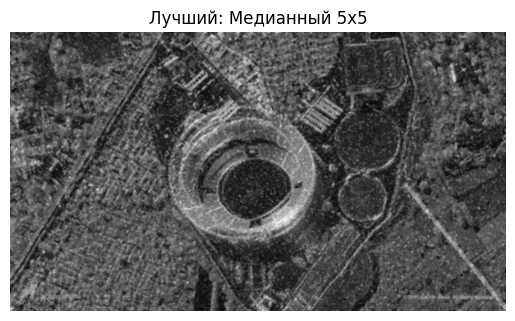

In [121]:
# Сравнение результатов для гауссова шума
filters_gauss = [
    ('Медианный 3x3', image_gauss_median3),
    ('Медианный 5x5', image_gauss_median5),
    ('Гаусс 3x3', image_gauss_gauss3),
    ('Гаусс 5x5', image_gauss_gauss5),
    ('Билатеральный 50', image_gauss_bilat1),
    ('Билатеральный 100', image_gauss_bilat2),
    ('NLM h=20', image_gauss_nlm)
]

best_mse_gauss = float('inf')
best_ssim_gauss = -1
best_filter_gauss = ""

print("Результаты для гауссова шума:")
for name, filtered_image in filters_gauss:
    mse = mean_squared_error(image_gray, filtered_image)
    ssim = structural_similarity(image_gray, filtered_image)
    
    print(f"{name}: MSE={mse:.2f}, SSIM={ssim:.4f}")
    
    if mse < best_mse_gauss and ssim > best_ssim_gauss:
        best_mse_gauss = mse
        best_ssim_gauss = ssim
        best_filter_gauss = name

print(f"\nЛучший фильтр для гауссова шума: {best_filter_gauss}")
print(f"MSE: {best_mse_gauss:.2f}, SSIM: {best_ssim_gauss:.4f}")

best_gauss_image = next(img for name, img in filters_gauss if name == best_filter_gauss)

plt.imshow(best_gauss_image, cmap='gray')
plt.title(f'Лучший: {best_filter_gauss}')
plt.axis('off')
plt.show()

In [116]:
# Фильтры для соль и перец шума

# Медианный фильтр
image_sp_median3 = cv2.medianBlur(bg_image, 3)
image_sp_median5 = cv2.medianBlur(bg_image, 5)

# Фильтр Гаусса
image_sp_gauss3 = cv2.GaussianBlur(bg_image, (3, 3), 0)
image_sp_gauss5 = cv2.GaussianBlur(bg_image, (5, 5), 0)

# Билатеральный фильтр
image_sp_bilat1 = cv2.bilateralFilter(bg_image, 9, 50, 50)
image_sp_bilat2 = cv2.bilateralFilter(bg_image, 9, 100, 100)

# Фильтр нелокальных средних
image_sp_nlm = cv2.fastNlMeansDenoising(bg_image, h=20)

Результаты для соль и шума:
Медианный 3x3: MSE=953.79, SSIM=0.4643
Медианный 5x5: MSE=261.71, SSIM=0.5855
Гаусс 3x3: MSE=1652.43, SSIM=0.2211
Гаусс 5x5: MSE=1210.76, SSIM=0.2789
Билатеральный 50: MSE=7045.86, SSIM=0.0508
Билатеральный 100: MSE=3075.76, SSIM=0.1114
NLM h=20: MSE=7863.84, SSIM=0.0645

Лучший фильтр для соль и перец шума: Медианный 5x5
MSE: 261.71, SSIM: 0.5855


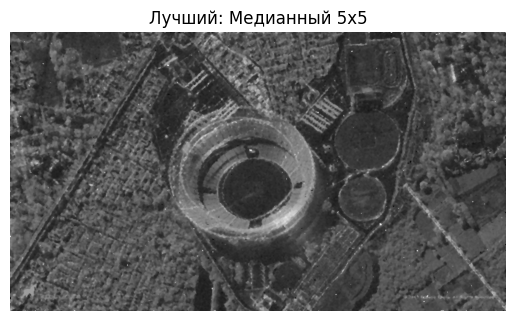

In [117]:
# Сравнение результатов для соль и перец шума
filters_sp = [
    ('Медианный 3x3', image_sp_median3),
    ('Медианный 5x5', image_sp_median5),
    ('Гаусс 3x3', image_sp_gauss3),
    ('Гаусс 5x5', image_sp_gauss5),
    ('Билатеральный 50', image_sp_bilat1),
    ('Билатеральный 100', image_sp_bilat2),
    ('NLM h=20', image_sp_nlm)
]

best_mse_sp = float('inf')
best_ssim_sp = -1
best_filter_sp = ""

print("Результаты для соль и шума:")
for name, filtered_image in filters_sp:
    mse = mean_squared_error(image_gray, filtered_image)
    ssim = structural_similarity(image_gray, filtered_image)
    
    print(f"{name}: MSE={mse:.2f}, SSIM={ssim:.4f}")
    
    if mse < best_mse_sp and ssim > best_ssim_sp:
        best_mse_sp = mse
        best_ssim_sp = ssim
        best_filter_sp = name

print(f"\nЛучший фильтр для соль и перец шума: {best_filter_sp}")
print(f"MSE: {best_mse_sp:.2f}, SSIM: {best_ssim_sp:.4f}")

best_sp_image = next(img for name, img in filters_sp if name == best_filter_sp)

plt.imshow(best_sp_image, cmap='gray')
plt.title(f'Лучший: {best_filter_sp}')
plt.axis('off')
plt.show()

In [36]:
# Фильтры для постоянного шума

# Медианный фильтр
image_const_median3 = cv2.medianBlur(noisy_image, 3)
image_const_median5 = cv2.medianBlur(noisy_image, 5)

# Фильтр Гаусса
image_const_gauss3 = cv2.GaussianBlur(noisy_image, (3, 3), 0)
image_const_gauss5 = cv2.GaussianBlur(noisy_image, (5, 5), 0)

# Билатеральный фильтр
image_const_bilat1 = cv2.bilateralFilter(noisy_image, 9, 50, 50)
image_const_bilat2 = cv2.bilateralFilter(noisy_image, 9, 100, 100)

# Фильтр нелокальных средних
image_const_nlm = cv2.fastNlMeansDenoising(noisy_image, h=20)

Результаты для гауссова шума:
Медианный 3x3: MSE=6107.33, SSIM=0.3282
Медианный 5x5: MSE=5920.22, SSIM=0.3426
Гаусс 3x3: MSE=5785.56, SSIM=0.4447
Гаусс 5x5: MSE=5707.20, SSIM=0.4717
Билатеральный 50: MSE=6090.90, SSIM=0.3206
Билатеральный 100: MSE=5753.17, SSIM=0.4165
NLM h=20: MSE=7244.58, SSIM=0.2147

Лучший фильтр для гауссова шума: Гаусс 5x5
MSE: 5707.20, SSIM: 0.4717


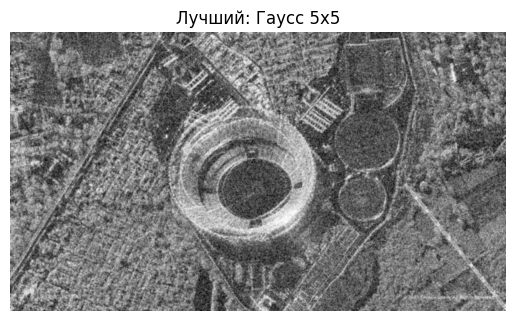

In [ ]:
# Сравнение результатов для постоянного шума
filters_const = [
    ('Медианный 3x3', image_const_median3),
    ('Медианный 5x5', image_const_median5),
    ('Гаусс 3x3', image_const_gauss3),
    ('Гаусс 5x5', image_const_gauss5),
    ('Билатеральный 50', image_const_bilat1),
    ('Билатеральный 100', image_const_bilat2),
    ('NLM h=20', image_const_nlm)
]

best_mse_const = float('inf')
best_ssim_const = -1
best_filter_const = ""

print("Результаты для постоянного шума:")
for name, filtered_image in filters_const:
    mse = mean_squared_error(image_gray, filtered_image)
    ssim = structural_similarity(image_gray, filtered_image)
    
    print(f"{name}: MSE={mse:.2f}, SSIM={ssim:.4f}")
    
    if mse < best_mse_const and ssim > best_ssim_const:
        best_mse_const = mse
        best_ssim_const = ssim
        best_filter_const = name

print(f"\nЛучший фильтр для постоянного шума: {best_filter_const}")
print(f"MSE: {best_mse_const:.2f}, SSIM: {best_ssim_const:.4f}")

best_const_image = next(img for name, img in filters_const if name == best_filter_const)

plt.imshow(best_const_image, cmap='gray')
plt.title(f'Лучший: {best_filter_const}')
plt.axis('off')
plt.show()